In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import numpy as np
import os
import jax.numpy as jnp
import jax
import pickle
import scipy as sp
from jax import vmap, jit, grad, value_and_grad

In [3]:
def hermite(k, u):
    return sp.special.eval_hermitenorm(k, u) / np.sqrt(np.math.factorial(k))

def teacher(z):
#     return hermite(1, z[:,0]) + hermite(2, z[:,0]) + hermite(2, z[:,1])
    return hermite(2, z[:,0]) + hermite(2, z[:,1])

q = 2
def fstar(x):
    y = teacher(x[:,:q])
    return y

In [4]:
n = 10000
d = 20
k = 2

X = np.random.randn(n, d)
y = fstar(X)

Wstar = np.zeros((d, q))
Wstar[:q,:q] = np.eye(q)

In [5]:
assert k == 2

def phi(z):
    return jnp.array([1, z[0], z[1], z[0] ** 2, z[1] ** 2, z[0] * z[1]])

phi = jit(vmap(phi))

In [6]:
# compute and fix the inverse covariance, since it shouldn't vary with rotations (and to avoid backprop on matrix inv)
XX = phi(X[:,:k])
invCov = jnp.linalg.inv(XX.T.dot(XX) / n)

In [7]:
def loss(W):
    theta = jnp.dot(invCov, jnp.mean(y[:,None] * phi(jnp.dot(X, W)), axis=0))
#     theta = jnp.dot(invCov, jnp.mean(y[:,None] * phi(jnp.dot(X, jax.lax.stop_gradient(W))), axis=0))  # TODO: stopgradient on W?
    preds = jnp.dot(phi(jnp.dot(X, W)), theta)
    return jnp.mean((preds - y) ** 2)

lossgrad = jit(grad(loss))
lossvalgrad = jit(value_and_grad(loss))

In [21]:
W = np.random.randn(d, k)
W, _ = sp.linalg.qr(W, mode='economic')
# U, _, V = np.linalg.svd(W, full_matrices=False)
# W = U.dot(V)

lr = 0.005
steps = 10000
res = []

for i in range(steps):
    lss, g = lossvalgrad(W)
    U, lambdas, V = np.linalg.svd(W.T.dot(Wstar))
    W -= lr * g
    W, _ = sp.linalg.qr(W, mode='economic')
#     U, _, V = np.linalg.svd(W, full_matrices=False)
#     W = U.dot(V)
    if i % 100 == 0:
        print(i, lss, lambdas) # , U[:,:].ravel())
        
    res.append({'it': i, 'loss': lss, 'lambdas': lambdas})


0 1.878367 [0.65212512 0.05702058] [ 0.68933732 -0.72444051 -0.72444051 -0.68933732]
100 1.1462121 [0.96520933 0.05646448] [ 0.66421268 -0.74754365 -0.74754365 -0.66421268]
200 0.9952277 [0.99907372 0.05469649] [ 0.61456871  0.7888633   0.7888633  -0.61456871]
300 0.9896244 [0.99945326 0.05262714] [ 0.57299202  0.81956095  0.81956095 -0.57299202]
400 0.98699003 [0.99943464 0.05052944] [ 0.5375122   0.84325597  0.84325597 -0.5375122 ]
500 0.9848825 [0.99942384 0.04840642] [ 0.5082331   0.86121955  0.86121955 -0.5082331 ]
600 0.9832261 [0.99941393 0.04628887] [ 0.4845926   0.87473997  0.87473997 -0.4845926 ]
700 0.9819595 [0.9994045  0.04419901] [ 0.46585426  0.88486146  0.88486146 -0.46585426]
800 0.9810117 [0.99939569 0.04215209] [ 0.45125535  0.89239487  0.89239487 -0.45125535]
900 0.980314 [0.99938769 0.04015651] [ 0.4400807   0.89795823  0.89795823 -0.4400807 ]
1000 0.97980684 [0.99938035 0.03821491] [ 0.43169407  0.90202008  0.90202008 -0.43169407]
1100 0.9794411 [0.99937393 0.0363

9300 0.97755164 [0.99933753 0.03047005] [-0.3693427  -0.92929327 -0.92929327  0.3693427 ]
9400 0.97754097 [0.99933773 0.03084265] [-0.36822356 -0.92973728 -0.92973728  0.36822356]
9500 0.9775304 [0.99933768 0.0312173 ] [-0.36710223 -0.9301806  -0.9301806   0.36710223]
9600 0.9775201 [0.99933766 0.03158678] [-0.36598067 -0.93062245 -0.93062245  0.36598067]
9700 0.9775096 [0.99933761 0.03195474] [-0.36485907 -0.93106276 -0.93106276  0.36485907]
9800 0.97749937 [0.99933776 0.03231946] [-0.36373732 -0.93150156 -0.93150156  0.36373732]
9900 0.97748923 [0.99933763 0.03268333] [-0.36261487 -0.93193908 -0.93193908  0.36261487]


Text(0.5, 1.0, 'lambdas')

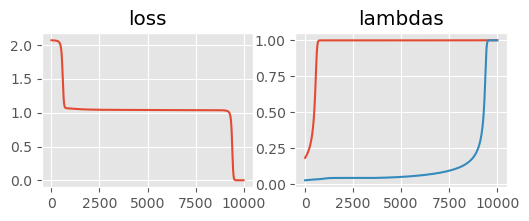

In [9]:
rr = res # [:1000]
its = [r['it'] for r in rr]
losses = [r['loss'] for r in rr]
lambda1 = [r['lambdas'][0] for r in rr]
lambda2 = [r['lambdas'][1] for r in rr]

plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.plot(its, losses)
plt.title('loss')
plt.subplot(1, 2, 2)
plt.plot(its, lambda1)
plt.plot(its, lambda2)
plt.title('lambdas')

In [67]:
W, Wstar, np.linalg.norm(W, axis=0)

(array([[-0.1809262 , -0.9827058 ],
        [ 0.41072875, -0.08534285],
        [-0.25144693,  0.03423086],
        [-0.02855617, -0.00833405],
        [ 0.6407563 , -0.10743561],
        [-0.3606526 ,  0.07487538],
        [ 0.23987298, -0.04467646],
        [-0.01592054, -0.01295675],
        [-0.36877692,  0.07663158],
        [-0.0099373 , -0.0240796 ]], dtype=float32),
 array([[1., 0.],
        [0., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([1., 1.], dtype=float32))

In [13]:
U[:,0]

array([0.16506657, 0.98628243])